In [1]:
import pandas as pd

# read data
reviews_df = pd.read_csv('E:/LBSIM/Trimester 4/TP/reviews.csv')

# create the label
reviews_df["is_bad_review"] = reviews_df["rating"].apply(lambda x: 1 if x < 3 else 0)

# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [3]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

#export_csv = reviews_df.to_csv(r'E:\LBSIM\Trimester 4\TP\posneg.csv', index = None, header=True)

In [6]:
# create doc2vec vector columns
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

unable to import 'smart_open.gcs', disabling that module


0    0.867116
1    0.132884
Name: is_bad_review, dtype: float64

In [7]:
# wordcloud function
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

<Figure size 2000x2000 with 1 Axes>

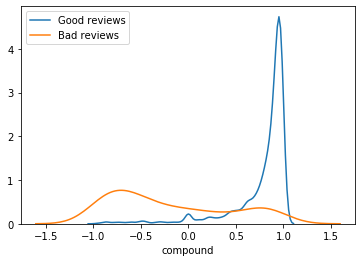

In [8]:
# plot sentiment distribution for positive and negative reviews
import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)